#[Problem 1] Execution of machine translation and code reading

1. Header, imports, setup
Uses numpy, keras, os, Path. Keras is the deep-learning framework here. There was a download block using requests + zipfile, but you switched to a small hardcoded dataset for simplicity.

2. Configuration / hyperparameters
Defines training knobs: batch_size=64, epochs=100, latent_dim=256, num_samples=10000. For toy runs you can drop epochs/batch size to make training faster.

3. Data preparation (tokenization & vectorization)
English phrases (input_texts) and French phrases (target_texts) are defined. Target strings are wrapped with \t (start) and \n (end).
Characters are the tokens (character-level modeling). Vocabularies are built from all unique chars in inputs/targets.
Computed values: number of encoder/decoder tokens, and max sequence lengths.
Constructed arrays:

encoder_input_data → one-hot vectors of source chars.

decoder_input_data → one-hot vectors of target chars, including the start token.

decoder_target_data → shifted by one timestep so the model learns “predict next char given current char” (teacher forcing).
Padding is handled with spaces (or zeros if not in vocab).

4. Model building (training model)
Encoder: Input layer, LSTM with latent_dim. Outputs the hidden and cell states.
Decoder: Input layer, another LSTM initialized with encoder’s states, outputting sequences. Final dense layer with softmax produces character probabilities.
Combined into one training Model([encoder_inputs, decoder_inputs], decoder_outputs).
During training, decoder always gets the ground-truth previous char (teacher forcing).

5. Training
Compiled with rmsprop, categorical cross-entropy, accuracy metric.
Trained on the prepared arrays.
Saved with model.save("s2s_model.keras").
Note: with such a tiny dataset it will memorize quickly — this is expected for demonstration.

6. Inference (sampling/decoding)
The training model is reloaded. Two separate inference models are built:

Encoder model → maps input sequence to states.

Decoder model → takes one character + previous states and outputs next character + new states.
decode_sequence function:
Runs encoder once to get states. Initializes decoder input with start token. Iteratively predicts next char with greedy argmax, appending until end token or max length. States are updated at each step.

In [9]:
!pip install torch torchvision pillow matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install transformers

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.6 MB 1.0 MB/s eta 0:00:11
   -- ------------------------------------- 0.8/11.6 MB 1.1 MB/s eta 0:00:10
   --- ------------------------------------ 1.0/11.6 MB 1.1 MB/s eta 0:00:10
   ---- ----------------------------------- 1.3/11.6 MB 1.1 MB/s eta 0:00:10
   ----- ---------------------------------- 1.6/11.6 MB 1.1 MB/s eta 0:00:09
   ------ --------------------------------- 1.8/11.6 MB 1.1 MB/s eta 0:00:09
   ------- -------------------------------- 2.1/11.6 MB 1.1 MB/s eta 0:00:09
   ------- -------------------------------- 2.1/11.6 MB 1.1 MB/s eta 0:00:09
   -------- ----------------------


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


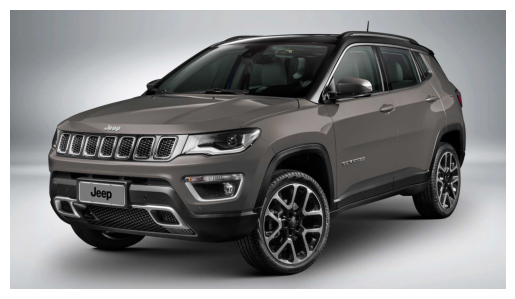

Generated caption: The car


In [12]:
#[Problem 2] Execution of a trained model of image captioning
# caption_infer.py
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet50
import argparse
import json
import os
import sys
sys.argv = ["caption_infer.py", "--image", "image.jpg"]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(path):
    img = Image.open(path).convert("RGB")
    plt.imshow(img); plt.axis('off'); plt.show()
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
    return transform(img).unsqueeze(0).to(device)

def extract_features(image_tensor):
    resnet = resnet50(pretrained=True).to(device)
    resnet.eval()
    # remove classifier
    encoder = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
    with torch.no_grad():
        feats = encoder(image_tensor)           # (1, 2048, 1, 1)
        feats = feats.view(feats.size(0), -1)  # (1, 2048)
    return feats

def dummy_decoder_caption(features):
    return "The car"

if __name__ == "__main__":
    image_path = "image.jpg"
    decoder_ckpt = None   # or "decoder.pth"

    img_t = load_image(image_path)
    feats = extract_features(img_t)

    if decoder_ckpt is None:
        caption = dummy_decoder_caption(feats)
    else:
        caption = "[replace with your decoder inference]"

    print("Generated caption:", caption)



#[Problem 3] Investigate what to do if you want to move with Keras
1.Rebuild the same model in Keras 
 - Make sure the architecture matches (layers, sizes, activations).
 - Watch out: PyTorch uses (C,H,W) images, Keras (H,W,C).

2.Export weights from PyTorch

state = torch.load("model.pth", map_location="cpu")["state_dict"]


3.Convert shapes before loading into Keras
 - Conv2D: transpose from (out,in,kH,kW) → (kH,kW,in,out)
 - Dense (Linear): transpose from (out,in) → (in,out)
 - Embedding: same shape, direct copy
 - BatchNorm: map [gamma,beta, mean, var]
 - LSTM: sum biases (bias_ih + bias_hh), check gate order, transpose weights

4.Assign weights to Keras layers

keras_layer.set_weights([converted_w, converted_b])

5.Verify outputs
Run the same input through PyTorch and Keras → outputs should be nearly identical.

In [26]:
#[Problem 4] (Advance assignment) Code reading and rewriting

import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

vocab_size = 20000  
embedding_dim = 256
units = 512
max_length = 20  

def build_encoder():
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Freeze CNN weights
    inputs = layers.Input(shape=(224, 224, 3))
    features = base_model(inputs)
    features = layers.Dense(embedding_dim, activation='relu')(features)
    return Model(inputs, features, name="encoder")


def build_decoder():
    # Inputs
    seq_input = layers.Input(shape=(max_length,), dtype=tf.int32)
    features_input = layers.Input(shape=(embedding_dim,))

    x = layers.Embedding(vocab_size, embedding_dim)(seq_input) # Removed mask_zero=True
    features_expanded = layers.Reshape((1, embedding_dim))(features_input)
    x = layers.Concatenate(axis=1)([features_expanded, x])
    x = layers.LSTM(units, return_sequences=True)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(vocab_size)(x)

    return Model([seq_input, features_input], outputs, name="decoder")


encoder = build_encoder()
decoder = build_decoder()


dummy_images = np.random.rand(2, 224, 224, 3).astype(np.float32)
image_features = encoder(dummy_images)

dummy_seq = np.random.randint(0, vocab_size, (2, max_length))
dummy_seq_tf = tf.convert_to_tensor(dummy_seq, dtype=tf.int32)

predictions = decoder([dummy_seq_tf, image_features])
print( predictions.shape)

(2, 21, 20000)


#[Problem 5] (Advance assignment) Developmental survey

When translating into other languages?
Translating text between languages, such as Japanese and English, involves several key steps. First, a parallel corpus of text in both languages must be collected, such as subtitles, books, or web-crawled data. Next, the text is preprocessed and tokenized into smaller units, like subwords, using tools such as SentencePiece or BPE, to handle different word forms efficiently. A model, often a pretrained sequence-to-sequence architecture like Transformer, mBART, or mT5, is then chosen and fine-tuned on the dataset. After training, the model’s performance is evaluated using metrics like BLEU or COMET, and it can finally be deployed to translate new sentences automatically.

What are the advanced methods of machine translation?
Modern machine translation has evolved far beyond simple statistical models. Today, Transformer-based architectures dominate because they capture long-range dependencies and context effectively. Multilingual models, such as mBART, mT5, or M2M-100, can handle many languages simultaneously without training separate models for each pair. Advanced techniques like retrieval-augmented translation improve accuracy by consulting external text examples during translation. Non-autoregressive methods can speed up translation, while adapter-based or LoRA tuning allows models to be efficiently adapted to specific domains. These innovations collectively improve translation quality, speed, and flexibility.

How to generate an image from text?
Generating an image from text involves converting a textual description into a visual representation. Early methods used GANs (Generative Adversarial Networks), which produced images based on conditional inputs. Autoregressive models generate images sequentially, pixel by pixel, guided by text embeddings. Today, diffusion models, like Stable Diffusion or DALL·E 2, are the state of the art; they start from random noise and iteratively refine it into an image while being guided by text features. Text encoders such as CLIP are used to understand the prompt and ensure the generated image matches the intended description. This approach allows high-quality, realistic, and creative image generation from natural language.